# Lab 1 : Generative Models (Autoencoders)
```
- [S24] Advanced Machine Learning, Innopolis University
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Undercomplete, overcomplete, Sparse and Denoising Autoencoder
2. Task 1
3. Variational Autoencoders
4. Task 2
```

<hr>

## 1. Undercomplete, overcomplete, Sparse and Denoising Autoencoder

PCA vs. Undercomplete autoencoders
* Autoencoders are much flexible than PCA.
* Neural Network activation functions introduce “non-linearities” in encoding, but PCA only linear transformation.

### 1.1 Undercomplete Example

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import torchvision
import torchvision.transforms as transforms
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1.2 Defining Undercomplete Autoencoder

In [ ]:
## Undercomplete
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
      super(autoencoder, self).__init__()
      # Step 1 : Define the encoder
      self.encoder = nn.Sequential(
          nn.Linear(input_size, input_size//2),
          nn.ReLU(),
          nn.Linear(input_size//2, latent_dim)
      )

      # Step 2 : Define the decoder
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, input_size//2),
          nn.ReLU(),
          nn.Linear(input_size//2, input_size)
      )

      # Step 3 : Initialize the weights (optional)
      self.encoder.apply(self.__init_weights)
      self.decoder.apply(self.__init_weights)

    def forward(self, x):
      # Step 1: Pass the input through encoder to get latent representation
      z = self.encoder(x)
      # Step 2: Take latent representation and pass through decoder
      x = self.decoder(z)
      return x

    def encode(self,input):
      #Step 1: Pass the input through the encoder to get latent representation
      return self.encoder(input)

    def __init_weights(self,m):
      #Init the weights (optional)
      if type(m) == nn.Linear:
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

### 1.3 Define training parameters

```
Step 1: Set training parameters (batch size, learning rate, optimizer, number of epochs, loss function)
Step 2: Create dataset (Randomly generated)
Step 3: Create data loader
Step 4: Define the training loop
```

In [ ]:
batchSize = 100
learning_rate = 0.01
num_epochs = 3
sample = torch.randn((batchSize,1,64))
AE = autoencoder(64,5).to(device)
print(AE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(AE.parameters(),lr=learning_rate)

#Create a random dataset
data_loader = DataLoader(TensorDataset(torch.randn((1000,1,64))),batch_size=32,shuffle=True)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
)


In [ ]:
print(sample.size)

<built-in method size of Tensor object at 0x78dbc7b4ff60>


### 1.4 AE Training Loop

In [ ]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X in data_loader:
        X = X[0].to(device)

        optimizer.zero_grad()
        # forward
        output = AE(X)
        loss = criterion(output, X)

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # log
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))

epoch [1/3], loss:0.8951
epoch [2/3], loss:0.8669
epoch [3/3], loss:0.9563


## 2. Task 1 (Regularized Autoencoder)

Regularized autoencoders use a loss function that encourages the model to have other properties besides the ability to copy its input to its output.

* **Sparse Autoencoders** : It impose a constraint in its loss by adding a regularization term in the loss function.
$$L(x,\hat{x}) + λ \sum_{i}||h_i||$$
where $h_i$ is the activations of the hidden layers

  **Regularization Form** : It can be L1 regularization or Any other kinds of penalties are possible


* **Denoising Autoencoder** : a special autoencoder that is robust to noise. By adding stochastic noise, we force Autoencoder to learn more robust features


<font color='red'><strong>TASK 1.1 :</strong> Implement and train a Sparse Autoencoder for 1D data of your choice (data points should be more than 5000)</font>


<font color='red'><strong>TASK 1.2 :</strong> Implement and train a Denoising Autoencoder for CIFAR 10 dataset. Choose one class from the 10 classes</font>


In [ ]:
def linear(in_size, out_size, relu=True):
  return nn.Sequential(
      nn.Linear(in_size, out_size),
      nn.ReLU()
  ) if relu else nn.Linear(in_size, out_size)


class SparseAutoencoder(nn.Module):
  def __init__(self, input_size, latent_dim):
      super(SparseAutoencoder, self).__init__()
      # Step 1 : Define the encoder
      self.encoder = nn.Sequential(
          linear(input_size, input_size//2),
          linear(input_size//2, latent_dim, relu=False)
      )

      # Step 2 : Define the decoder
      self.decoder = nn.Sequential(
          linear(latent_dim, input_size//2),
          linear(input_size//2, input_size)
      )

  def forward(self, x):
    z = self.encoder(x)
    x = self.decoder(z)
    return x



In [ ]:
def l2_loss(autoencoder, x):
  loss = 0
  values = x
  autoencoder.eval()
  for (model_name, model) in dict(autoencoder.named_children()).items():
    for fc_layer in model.children():
      values = nn.functional.relu(fc_layer(values))
      loss += torch.mean(torch.norm(values))
  return loss

In [ ]:
batchSize = 64
learning_rate = 0.01
num_epochs = 3
reg_param = 0.001

sample = torch.randn((batchSize,1,64))
AE = SparseAutoencoder(64,7).to(device)
print(AE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(AE.parameters(),lr=learning_rate)

#Create a random dataset
data_loader = DataLoader(TensorDataset(sample),batch_size=batchSize,shuffle=True)

SparseAutoencoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=32, out_features=7, bias=True)
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=7, out_features=32, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
    )
  )
)


In [ ]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X in data_loader:
        X = X[0].to(device)

        optimizer.zero_grad()
        # forward
        output = AE(X)
        loss = criterion(output, X) + reg_param * l2_loss(AE,X)

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # log
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, epoch_loss))

epoch [1/3], loss:1.0547
epoch [2/3], loss:1.0406
epoch [3/3], loss:1.0320


#Denoising autoencoder

In [ ]:
def linear(in_size, out_size, relu=True):
  return nn.Sequential(
      nn.Linear(in_size, out_size),
      nn.ReLU()
  ) if relu else nn.Linear(in_size, out_size)

class DenoisingAutoencoder(nn.Module):
  def __init__(self, input_size, latent_dim):
      super(DenoisingAutoencoder, self).__init__()
      # Step 1 : Define the encoder
      self.encoder = nn.Sequential(
          nn.Linear(input_size, input_size//2),
          nn.ReLU(),
          nn.Linear(input_size//2, latent_dim)
      )

      # Step 2 : Define the decoder
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, input_size//2),
          nn.ReLU(),
          nn.Linear(input_size//2, input_size)
      )

  def forward(self, x):
    z = self.encoder(x)
    x = self.decoder(z)
    return x

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


# select deers from cifar10
deer_train_indices = [i for i, (_, label) in enumerate(trainset) if label == 4]
deer_test_indices = [i for i, (_, label) in enumerate(testset) if label == 4]

deer_train_loader = DataLoader(trainset, batch_size=64, sampler=torch.utils.data.sampler.SubsetRandomSampler(deer_train_indices))
deer_test_loader = DataLoader(testset, batch_size=5, sampler=torch.utils.data.sampler.SubsetRandomSampler(deer_test_indices))

100%|██████████| 170498071/170498071 [00:02<00:00, 65149116.29it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


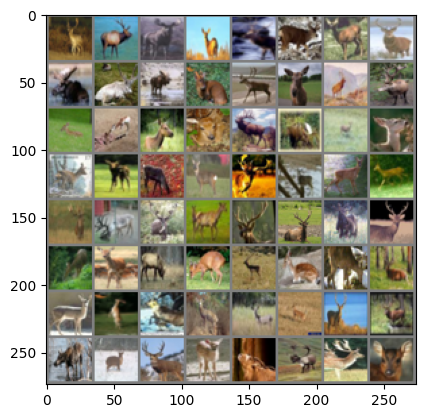

deer-0 deer-1 deer-2 deer-3 deer-4 deer-5 deer-6 deer-7 deer-8 deer-9 deer-10 deer-11 deer-12 deer-13 deer-14 deer-15 deer-16 deer-17 deer-18 deer-19


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(deer_train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'deer-{j}' for j in range(batch_size)))

In [ ]:
from tqdm import tqdm
input_size = 32*32*3
hidden_size = 128
latent_dim = 100
output_size = input_size
noise_factor = 0.01
AE = DenoisingAutoencoder(input_size, latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(AE.parameters(), lr=0.001)
num_epochs = 50

In [ ]:
#train
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X in deer_train_loader:
        input, _ = X
        input = input.view(input.size(0), -1).to(device)

        noisy_input = input + noise_factor * torch.randn_like(input)

        optimizer.zero_grad()
        # forward
        output = AE(noisy_input)
        loss = criterion(output, input)

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # log
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, epoch_loss))

epoch [1/50], loss:6.0727
epoch [2/50], loss:3.3786
epoch [3/50], loss:2.7714
epoch [4/50], loss:2.5344
epoch [5/50], loss:2.2766
epoch [6/50], loss:2.0845
epoch [7/50], loss:2.0346
epoch [8/50], loss:1.9652
epoch [9/50], loss:1.8034
epoch [10/50], loss:1.7003
epoch [11/50], loss:1.6793
epoch [12/50], loss:1.6162
epoch [13/50], loss:1.6594
epoch [14/50], loss:1.6047
epoch [15/50], loss:1.5466
epoch [16/50], loss:1.4890
epoch [17/50], loss:1.4758
epoch [18/50], loss:1.5023
epoch [19/50], loss:1.5594
epoch [20/50], loss:1.5137
epoch [21/50], loss:1.4061
epoch [22/50], loss:1.3503
epoch [23/50], loss:1.4137
epoch [24/50], loss:1.3952
epoch [25/50], loss:1.3231
epoch [26/50], loss:1.3104
epoch [27/50], loss:1.3168
epoch [28/50], loss:1.2854
epoch [29/50], loss:1.3009
epoch [30/50], loss:1.3203
epoch [31/50], loss:1.2865
epoch [32/50], loss:1.2534
epoch [33/50], loss:1.4016
epoch [34/50], loss:1.3686
epoch [35/50], loss:1.3099
epoch [36/50], loss:1.2752
epoch [37/50], loss:1.2268
epoch [38/

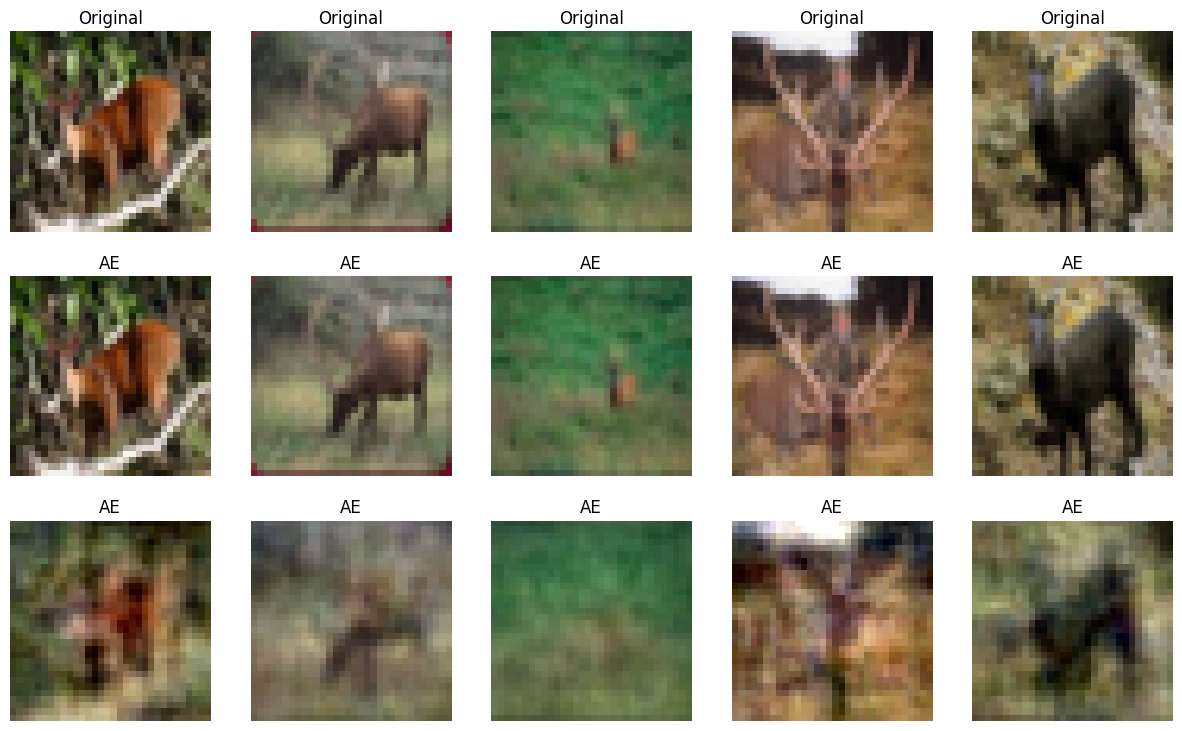

In [ ]:
#test
AE.eval()
for batch in deer_test_loader:
    input, _ = batch
    input = input.view(input.size(0), -1).to(device)
    noisy_input = input + noise_factor * torch.randn_like(input)

    output = AE(noisy_input)

    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    # Reshape for visualization and unnormalize
    input = torchvision.utils.make_grid(input)/ 2 + 0.5
    noisy_input = torchvision.utils.make_grid(noisy_input)/ 2 + 0.5
    output = torchvision.utils.make_grid(output)/ 2 + 0.5

    inputs = input.view(-1, 3, 32, 32)
    noisy_input = noisy_input.view(-1, 3, 32, 32)
    outputs = output.view(-1, 3, 32, 32)

    for i in range(5):
        axes[0, i].imshow(inputs[i].cpu().permute(1, 2, 0).detach().numpy())
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(noisy_input[i].cpu().permute(1, 2, 0).detach().numpy())
        axes[1, i].set_title('AE')
        axes[1, i].axis('off')

        axes[2, i].imshow(outputs[i].cpu().permute(1, 2, 0).detach().numpy())
        axes[2, i].set_title('AE')
        axes[2, i].axis('off')

    plt.show()
    break  # Показываем только первый батч для примера

## 3. Variational Autoencoders

![caption](https://learnopencv.com/wp-content/uploads/2020/11/vae-diagram-1-1024x563.jpg)


![](https://learnopencv.com/wp-content/uploads/2020/11/reparam-vae-2048x959.jpg)

Backpropagation works fine!!
However, we simply cannot do this for a random sampling process.

$$z \sim q(z|x^{i})$$

* It is basically divert the non-differentiable operation out of the network
* So that, even though we still involve a thing that is non-differentiable, at least it is out of the network
* Hence the network could still be trained.

To do so, we sample $\epsilon \sim N(0,I)$ and calculate:

$$z = \mu_{\phi}(x^{(i)}) + Σ^{1/2}_{\phi}(x^{(i)})\epsilon$$

**Key theories behind :** <br>
1. Change of variable
2. Loacation-Scale Transformation
3. [Law of The Unconscious Statistician](https://en.wikipedia.org/wiki/Law_of_the_unconscious_statistician)
4. [Evidence lower bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)

Then, $z$ will be a sample from $q(z|x^{(i)})$ as its a linear transformation of $\epsilon$ with mean $\mu_{\phi}(x^{(i)})$ and covariance $Σ^{1/2}_{\phi}(x^{(i)})$.

The sampling operation now occurs only for $\epsilon$, which we don’t need to backpropagate through.


**NOTE:** make a simplifying assumption that our covariance matrix only has nonzero values on the diagonal, allowing us to describe this information in a simple vector.

**NOTE** In order to deal with the fact that the network may learn negative values for $σ$ , we'll typically have the network learn $log$ $\sigma$ and exponentiate this value to get the latent distribution's variance

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import save_image

### 3.1 Get data (MNIST) and set Hyper-parameters

In [ ]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='../../data',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 34200930.42it/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23742785.93it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25195972.79it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11545775.01it/s]


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



### 3.2 Defining Variational Autoencoder

In [ ]:
# VAE model
import torch.nn.functional as F
class VAE(nn.Module):
  def __init__(self, image_size=784, h_dim=400, z_dim=20):
    super(VAE, self).__init__()
    # Encoder part
    self.fc1 = nn.Linear(image_size, h_dim)

    self.fc2 = nn.Linear(h_dim, z_dim) #mean
    self.fc3 = nn.Linear(h_dim, z_dim) #std

    # Decoder part
    self.fc4 = nn.Linear(z_dim, h_dim)
    self.fc5 = nn.Linear(h_dim, image_size)

  def encode(self, x):
    h = F.relu(self.fc1(x))
    return self.fc2(h), self.fc3(h)

  def reparameterize(self, mu, log_var):
    std = torch.exp(log_var/2) #can't be negative
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h = F.relu(self.fc4(z))
    return F.sigmoid(self.fc5(h))

  def forward(self, x):
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    x_reconst = self.decode(z)
    return x_reconst, mu, log_var

### 3.3 Training Variational Autoencoder

In [ ]:
model = VAE(image_size, h_dim, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Start training
mse_loss = nn.MSELoss()
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = mse_loss(x_reconst, x)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out,'./sampled-{}.png'.format(epoch+1))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, './reconst-{}.png'.format(epoch+1))

Epoch[1/15], Step [10/469], Reconst Loss: 0.1250
Epoch[1/15], Step [20/469], Reconst Loss: 0.0820
Epoch[1/15], Step [30/469], Reconst Loss: 0.0718
Epoch[1/15], Step [40/469], Reconst Loss: 0.0698
Epoch[1/15], Step [50/469], Reconst Loss: 0.0717
Epoch[1/15], Step [60/469], Reconst Loss: 0.0690
Epoch[1/15], Step [70/469], Reconst Loss: 0.0689
Epoch[1/15], Step [80/469], Reconst Loss: 0.0713
Epoch[1/15], Step [90/469], Reconst Loss: 0.0688
Epoch[1/15], Step [100/469], Reconst Loss: 0.0674
Epoch[1/15], Step [110/469], Reconst Loss: 0.0687
Epoch[1/15], Step [120/469], Reconst Loss: 0.0713
Epoch[1/15], Step [130/469], Reconst Loss: 0.0683
Epoch[1/15], Step [140/469], Reconst Loss: 0.0672
Epoch[1/15], Step [150/469], Reconst Loss: 0.0665
Epoch[1/15], Step [160/469], Reconst Loss: 0.0687
Epoch[1/15], Step [170/469], Reconst Loss: 0.0685
Epoch[1/15], Step [180/469], Reconst Loss: 0.0665
Epoch[1/15], Step [190/469], Reconst Loss: 0.0678
Epoch[1/15], Step [200/469], Reconst Loss: 0.0670
Epoch[1/1

## 4. Task 2 (variational autoencoder)

<font color='red'><strong>TASK 2.1 :</strong> Implement and train a variational autoencoder for cifar 10 data using the achitecture below for encoder and decoder as baseline (you can only improve the achitecture by extending the achitecture on top of baseline) </font>
<br>

<font color='red'><strong>TASK 2.2 :</strong> Implement a function that will generate images using the implemented vae</font>  


**Encoder Achitecture (baseline)**
- 3 convolutional layers whereby each layer is followed by batch normalization and relu activation function
  - Layer 1 : applies 32 filters
  - Layer 2 : applies 64 filters
  - Layer 3 : applies 128 filters

**Latent space**
- without activation

**Decoder Achitecture (baseline)**
- 3 deconvolutional layers whereby each layer is followed by batch normalization and relu activation function
- Mirror of the encoder network

**NB**: For both convolution and deconvolution `kernel_size=4, stride=2, padding=1`

In [ ]:
## Template code
## Write your code here

class VAE(nn.Module):
    def __init__(self, image_size=32*32*3, latent_dim=20):
        super(VAE, self).__init__()
        ## Encoder
        self.econv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.ebn1 = nn.BatchNorm2d(32)
        self.erelu1 = nn.ReLU(inplace=True)

        self.econv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) #16*16 -> 8*8
        self.ebn2 = nn.BatchNorm2d(64)
        self.erelu2 = nn.ReLU(inplace=True)

        self.econv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) #8*8 -> 4*4
        self.ebn3 = nn.BatchNorm2d(128)
        self.erelu3 = nn.ReLU(inplace=True)

        self.eflatten = nn.Flatten()

        self.efc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.efc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        ##Decoder
        self.dfc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.ddeconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dbn1 = nn.BatchNorm2d(64)
        self.drelu1 = nn.ReLU(inplace=True)

        self.ddeconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dbn2 = nn.BatchNorm2d(32)
        self.drelu2 = nn.ReLU(inplace=True)

        self.ddeconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
        self.dsigmoid = nn.Sigmoid()

    def reparametrize(self, mu, logvar):
        std = torch.exp(logvar/2) #can't be negative
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.erelu1(self.ebn1(self.econv1(x)))
        x = self.erelu2(self.ebn2(self.econv2(x)))
        x = self.erelu3(self.ebn3(self.econv3(x)))
        x = self.eflatten(x)
        return self.efc_mu(x), self.efc_logvar(x)

    def decode(self, z):
        x = self.dfc(z)
        x = x.view(x.size(0), 128, 4, 4)
        x = self.drelu1(self.dbn1(self.ddeconv1(x)))
        x = self.drelu2(self.dbn2(self.ddeconv2(x)))
        return self.dsigmoid(self.ddeconv3(x))

    def forward(self, x):
        #encoder
        mu, logvar = self.encode(x)

        z = self.reparametrize(mu, logvar)

        #decoder
        x_reconst = self.decode(z)
        return x_reconst, mu, logvar

latent_dim = 40
vae_model = VAE(latent_dim=latent_dim).to(device)
vae_model

VAE(
  (econv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (ebn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (erelu1): ReLU(inplace=True)
  (econv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (ebn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (erelu2): ReLU(inplace=True)
  (econv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (ebn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (erelu3): ReLU(inplace=True)
  (eflatten): Flatten(start_dim=1, end_dim=-1)
  (efc_mu): Linear(in_features=2048, out_features=40, bias=True)
  (efc_logvar): Linear(in_features=2048, out_features=40, bias=True)
  (dfc): Linear(in_features=40, out_features=2048, bias=True)
  (ddeconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dbn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
def vae_loss(x_reconst, x, mu, logvar):
    #BCE = nn.functional.binary_cross_entropy(x_reconst, x, reduction='sum')
    MSE = nn.functional.mse_loss(x_reconst, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [ ]:
from torch.autograd import Variable

learning_rate = 0.001
epochs = 20
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)
batch_size = 32

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    total_loss = 0
    for i, (x, _) in enumerate(train_loader):
        # input, _ = x
        # print(input.size())
        #input = input.view(input.size(0), -1).to(device)
        input = x.to(device)

        optimizer.zero_grad()

        x_reconst, mu, logvar = vae_model(input)
        loss = vae_loss(x_reconst, input, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print('Epoch {}, Loss: {:.3f}'.format(epoch + 1, total_loss / len(train_dataset)))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, latent_dim).to(device)
        out = vae_model.decode(z).view(-1, 1, 32, 32)
        save_image(out,'./sampled-{}.png'.format(epoch+1))

        # Save the reconstructed images
        out, _, _ = vae_model(input)
        x_concat = torch.cat([input.view(-1, 1, 32, 32), out.view(-1, 1, 32, 32)], dim=3)
        save_image(x_concat, './reconst-{}.png'.format(epoch+1))

Files already downloaded and verified
Epoch 1, Loss: 81.106
Epoch 2, Loss: 79.504
Epoch 3, Loss: 78.425
Epoch 4, Loss: 77.554
Epoch 5, Loss: 77.053
Epoch 6, Loss: 76.762
Epoch 7, Loss: 76.512
Epoch 8, Loss: 76.232
Epoch 9, Loss: 76.056
Epoch 10, Loss: 75.826
Epoch 11, Loss: 75.795
Epoch 12, Loss: 75.600
Epoch 13, Loss: 75.510
Epoch 14, Loss: 75.391
Epoch 15, Loss: 75.384
Epoch 16, Loss: 75.251
Epoch 17, Loss: 75.165
Epoch 18, Loss: 75.077
Epoch 19, Loss: 75.040
Epoch 20, Loss: 74.950


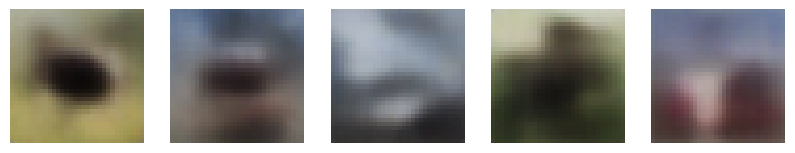

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def generate_images(vae, num_images=5):
    vae.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Generate random latent vectors
        latent_vectors = torch.randn(num_images, latent_dim).to(device)
        # Decode latent vectors to generate images
        generated_images = vae.decode(latent_vectors)

    # Plot the generated images
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        image = generated_images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(np.clip(image, 0, 1))
        plt.axis('off')

    plt.show()

# Assuming 'vae' is the trained VAE model
generate_images(vae_model, num_images=5)


## Resources

* [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
* [Variational inference: A review for statisticians](https://arxiv.org/pdf/1601.00670.pdf)
* [Tutorial on variational autoencoders](https://arxiv.org/pdf/1606.05908.pdf)
* [Stochastic Backpropagation and Approximate Inference in Deep Generative Models](https://arxiv.org/pdf/1401.4082.pdf)